El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

# Datos y Librerías

In [1]:
# Cargamos las librerias que nos servirán para nuestro análisis
%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from scipy.spatial import distance
from numpy.random import RandomState

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


In [2]:
# Cargamos los datos de cada tabla por separado

try:
    df = pd.read_csv('C:/Users/tomas/Downloads/car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

# Conociendo los datos

In [3]:
df.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  24/03/2016 11:52    480         NaN              1993  manual      0   
1  24/03/2016 10:58  18300       coupe              2011  manual    190   
2  14/03/2016 12:52   9800         suv              2004    auto    163   
3  17/03/2016 16:54   1500       small              2001  manual     75   
4  31/03/2016 17:25   3600       small              2008  manual     69   

   Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf   150000                  0    petrol  volkswagen         NaN   
1    NaN   125000                  5  gasoline        audi         yes   
2  grand   125000                  8  gasoline        jeep         NaN   
3   golf   150000                  6    petrol  volkswagen          no   
4  fabia    90000                  7  gasoline       skoda          no   

        DateCreated  NumberOfPictures  PostalCode          LastSeen  
0  24/03/2016 00:00                 0       70435  07/04/2016 03:16  
1  24/03/2016 00:00                 0       66954  07/04/2016 01:46  
2  14/03/2016 00:00                 0       90480  05/04/2016 12:47  
3  17/03/2016 00:00                 0       91074  17/03/2016 17:40  
4  31/03/2016 00:00                 0       60437  06/04/2016 10:17

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Necesitamos tratar con los valores vacíos en VehicleType, FuelType y NotRepaired.

In [5]:
df.describe()

Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

Claramente, hay algunas anomalías en las columnas de nuestro conjunto de datos. Por ejemplo, en la columna NumberOfPictures encontramos que está mayormente compuesta por ceros, lo que sugiere que no ofrece información útil y por ende será eliminada en la siguiente fase de análisis. Además, observamos un comportamiento inusual en las distribuciones de las columnas Price, RegistrationYear y Power, con un incremento significativo en el último cuartil de los datos. Este patrón es especialmente notable en la columna Power, donde el valor máximo es aproximadamente 14 veces mayor que el tercer cuartil. 

Por último, en la columna Mileage notamos que el valor máximo parece ser constante para la mayoría de los registros, lo cual podría indicar un límite establecido por la plataforma donde se publicaron estos anuncios.

# Columnas con valores atípicos

Comencemos viendo como se distribuyen los valores de Mileage.

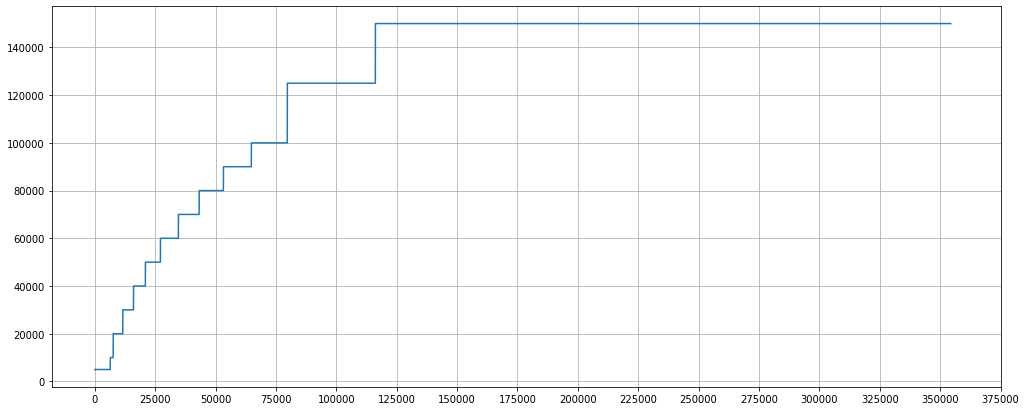

In [6]:
df['Mileage'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)
plt.xticks(np.arange(0,375001, 25000))
plt.show()

Los valores en esta columna parecen estar estandarizados, lo que sugiere que al publicar el anuncio, los usuarios tienen opciones predefinidas para seleccionar el kilometraje del automóvil, en lugar de tener la libertad de ingresar cualquier valor. Por lo tanto, podemos interpretar que el valor máximo en esta columna representa el límite superior establecido para el kilometraje del vehículo.

Veamos la columna Power ahora.

<AxesSubplot:>

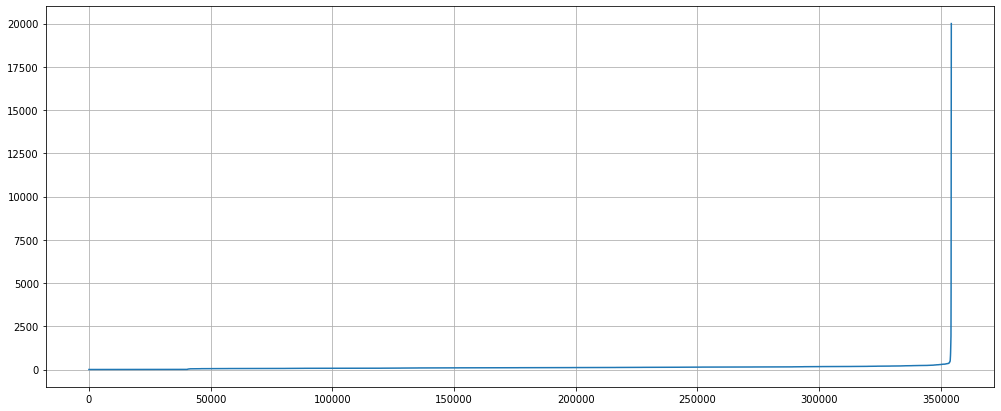

In [7]:
df['Power'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)

Claramente tenemos un problema al final de estos datos. Creemos un límite superior y veamos como se distribuyen los valores superiores.

<AxesSubplot:>

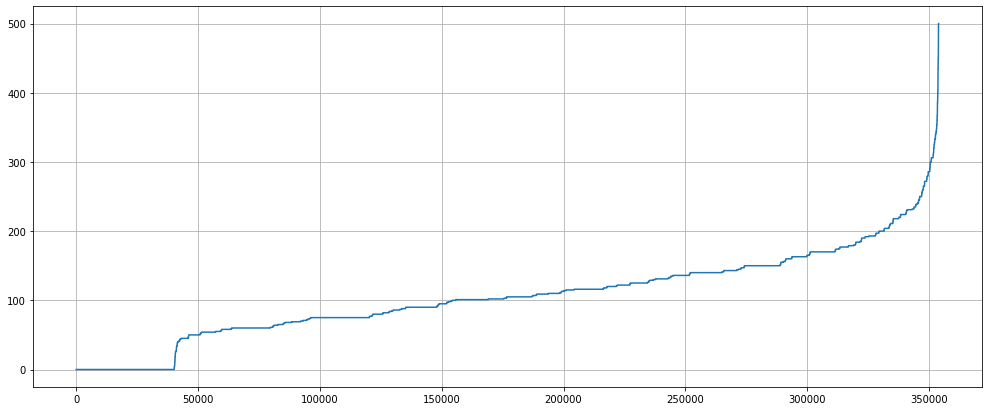

In [8]:
df[df['Power']<=500]['Power'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)

In [9]:

len(df[df['Power']>0])/len(df)

0.8864883779337357

Ahora, con una visión más clara de los valores en esta columna, identificamos la presencia de algunos anuncios con una potencia de 0 en el extremo inferior. Esta discrepancia carece de sentido y, aunque representa más del 10% de los datos, es necesario eliminar estas filas. Con su eliminación, esperamos también eliminar algunos de los valores vacíos y atípicos en otras columnas. Al observar el extremo superior, notamos un crecimiento desproporcionado en los valores después de alcanzar los 300 de potencia.

<AxesSubplot:>

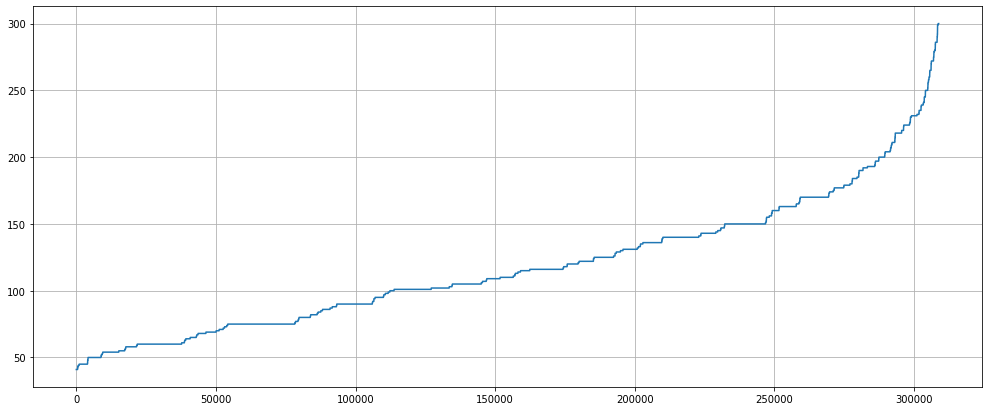

In [10]:
df[(df['Power']<=300) & (df['Power']>40)]['Power'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)

Ahora si tenemos un grupo de datos que se comportan más normalmente, aunque continuamos con extremos con comportamientos atípicos. Se podría llegar a considerar el rango entre 40 y 300 de poder.

Finalmente veamos la columna RegistrationYear.

<AxesSubplot:>

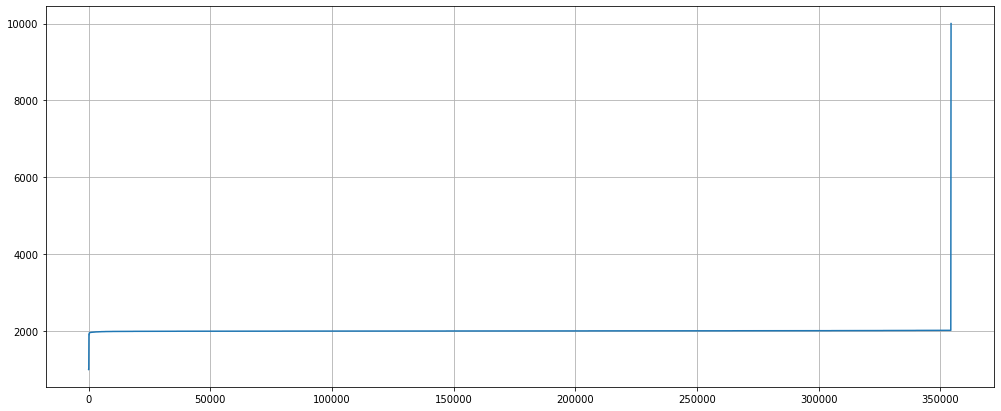

In [11]:
df['RegistrationYear'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)

Que increíbles anuncios, Desde automóviles del año 1000 hasta otros del año 9999. Sin embargo, nos encontramos con varios valores que están fuera de un rango razonable, como anuncios de autos registrados en el futuro o hace más de 100 años. Aunque algunos de estos podrían ser considerados como clásicos de colección, resulta improbable que los automóviles hayan sido registrados hace 500 o 1000 años. Por lo tanto, vamos a filtrar estos valores y examinar cómo se distribuyen los años restantes.

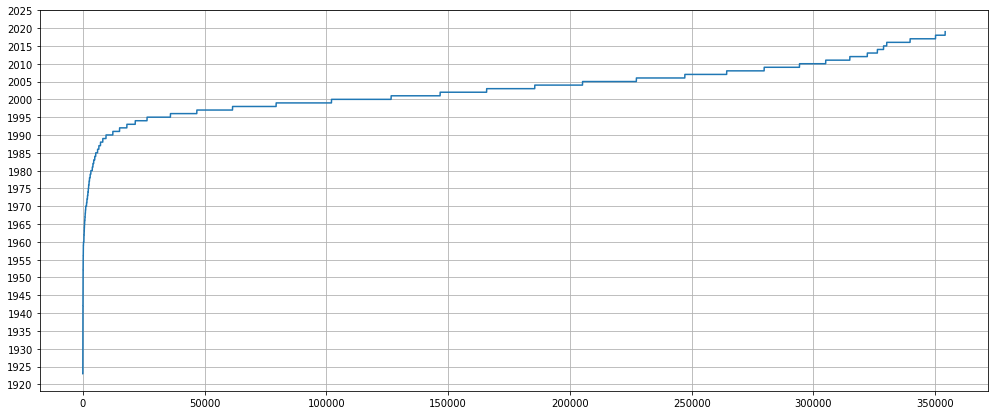

In [12]:
df[(df['RegistrationYear']<=2023) & (df['RegistrationYear']>1920)]['RegistrationYear'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)
plt.yticks(np.arange(1920, 2030, 5))
plt.show()

In [13]:
len(df[(df['RegistrationYear']<=2023) & (df['RegistrationYear']>1990)])/len(df)

0.9645002807807681

El rango de años ahora parece más razonable, aunque aún hay una cantidad significativa de anuncios de automóviles muy antiguos. Esta tendencia podría ser objeto de exploración por parte del equipo técnico o en investigaciones posteriores. Al igual que con la columna anterior, optaremos por considerar solo el rango que muestra un comportamiento más estable. Por lo tanto, nos centraremos en los anuncios con registros desde el año 1990 hasta el presente.

# Columnas categóricas

In [14]:
df['VehicleType'].value_counts(normalize=True)

sedan          0.288618
small          0.251929
wagon          0.205649
bus            0.090808
convertible    0.063756
coupe          0.051007
suv            0.037857
other          0.010376
Name: VehicleType, dtype: float64

Una gran variedad de tipos de automovil, aunque la mayoría de estos son de tipo sedan, small o wagon, también tenemos un pequeño grupo con tipo desconocido de automovil. Esta columna también cuenta con una importante cantidad de datos vacíos, en este caso los colocaremos en la categoría other.

In [15]:
df['Gearbox'].value_counts(normalize=True)

manual    0.80186
auto      0.19814
Name: Gearbox, dtype: float64

La mayoría de los autos son manuales, interesante considerando que la mayoría de los nuevos autos son automáticos de fábrica.

In [16]:
df['Model'].value_counts(normalize=True)

golf                  0.087347
other                 0.072972
3er                   0.059047
polo                  0.039042
corsa                 0.037560
                        ...   
serie_2               0.000024
rangerover            0.000012
serie_3               0.000012
serie_1               0.000006
range_rover_evoque    0.000006
Name: Model, Length: 250, dtype: float64

In [17]:
df['Model'].value_counts().describe()

count      250.000000
mean      1338.656000
std       3277.262009
min          2.000000
25%        145.250000
50%        369.000000
75%        888.750000
max      29232.000000
Name: Model, dtype: float64

<AxesSubplot:>

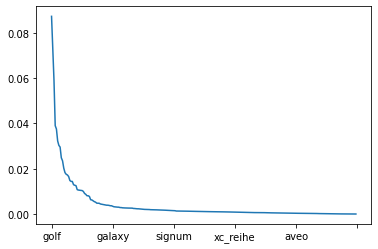

In [18]:
df['Model'].value_counts(normalize=True).plot()

Tenemos un total de 250 modelos diferentes. Aunque algunos son favoritos, la cantidad de anuncios por modelo es bastante baja. Debido a la gran diversidad de modelos, codificar esta columna para su procesamiento por parte de nuestros modelos de machine learning podría plantear un desafío significativo. Esto prolongaría considerablemente el tiempo de procesamiento y podría sesgar las predicciones al haber tantas disparidades en la cantidad de anuncios por modelo. En consecuencia, puede ser más prudente eliminar esta columna del conjunto de datos.

In [19]:
df['FuelType'].value_counts(normalize=True)

petrol      0.673000
gasoline    0.307085
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: FuelType, dtype: float64

Aunque la mayoría de los autos parecen seguir siendo de combustión interna, es agradeble comenzar a ver algunos autos con otras formas de energía. Al igual que con la columna VehicleType, llenaremos los datos vacíos de esta columna con la categoría other.

In [20]:
df['Brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

In [21]:
df['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

Esta columna es además la que tiene la mayor cantidad de datos faltantes. Si vemos la mayoría de los datos existentes, podemos ver como llenar el resto de los datos. Por la gran mayoría que tienen, los datos vacíos pasarán a ser de la categoría no. También es bueno mencionar que esta columna podrá codificarse fácilmente sin la necesidad de crear columnas adicionales.

# Preparación de los datos

Antes de alterar los datos al prepararlos, creemos una copia de los datos por si se necesitan comparaciones.

In [22]:
df_raw = df.copy()

# Columnas a eliminar

Nuestros modelos tendrán problemas con las columnas de fechas y las columnas PostalCode y Model solo confundirán a nuestros modelos. Eliminaremos todas estas columnas y le ahorraremos tiempo a los modelos.

In [23]:
# Eliminamos las columnas
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis=1)

In [24]:
# Comprobamos como queda el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Mileage            354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


# Podado de datos atípicos
Apliquemos los límites que encontramos en la exploración de datos.

In [25]:
df = df[(df['Power']<=300) & (df['Power']>=40)]
df = df[(df['RegistrationYear']<=2023) & (df['RegistrationYear']>=1990)]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302760 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              302760 non-null  int64 
 1   VehicleType        280532 non-null  object
 2   RegistrationYear   302760 non-null  int64 
 3   Gearbox            296626 non-null  object
 4   Power              302760 non-null  int64 
 5   Model              290821 non-null  object
 6   Mileage            302760 non-null  int64 
 7   RegistrationMonth  302760 non-null  int64 
 8   FuelType           282432 non-null  object
 9   Brand              302760 non-null  object
 10  NotRepaired        255375 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.7+ MB


Al parecer teníamos razón. La grán mayoría de los datos vacíos correspondía a los anuncios fuera de rangos normales. Ahora que tenemos datos dentro de rangos razonables, continuemos llenando los espacios que nos quedan.

# Datos vacíos

In [27]:
df['VehicleType'].fillna(value='other', axis=0, inplace=True)
df['FuelType'].fillna(value='other', axis=0, inplace=True)
df['Gearbox'].fillna(value='manual', axis=0, inplace=True)
df['NotRepaired'].fillna(value='no', axis=0, inplace=True)
df['Model'].fillna(value='unkown', axis=0, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302760 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              302760 non-null  int64 
 1   VehicleType        302760 non-null  object
 2   RegistrationYear   302760 non-null  int64 
 3   Gearbox            302760 non-null  object
 4   Power              302760 non-null  int64 
 5   Model              302760 non-null  object
 6   Mileage            302760 non-null  int64 
 7   RegistrationMonth  302760 non-null  int64 
 8   FuelType           302760 non-null  object
 9   Brand              302760 non-null  object
 10  NotRepaired        302760 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.7+ MB


# Columnas str
Ahora codifiquemos las columnas con datos de tipo str para que nuestros modelos no tengan problemas.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302760 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              302760 non-null  int64 
 1   VehicleType        302760 non-null  object
 2   RegistrationYear   302760 non-null  int64 
 3   Gearbox            302760 non-null  object
 4   Power              302760 non-null  int64 
 5   Model              302760 non-null  object
 6   Mileage            302760 non-null  int64 
 7   RegistrationMonth  302760 non-null  int64 
 8   FuelType           302760 non-null  object
 9   Brand              302760 non-null  object
 10  NotRepaired        302760 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.7+ MB


In [30]:
df_ = df.copy()

# Aplicamos el método OrdinalEncoder
enc = OrdinalEncoder()
df_enc = df_.copy()
df_enc[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox', 'Model', 'Brand']] = enc.fit_transform(df_[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox', 'Model', 'Brand']])

# Eliminamos las columnas Model y Brand por su gran cantidd de variables
df_ = df.drop(['Model', 'Brand'], axis=1)

# Creamos las variables dummies, excepto por las columnas Model y Brand por su gran cantidad
df_ohe = pd.get_dummies(df_, drop_first=True)

# Veamos como queda el set de datos
df_ohe.shape

(302760, 20)

# Features y Targets

In [31]:
rs = RandomState(54321) # Fijemos una semilla para estabilidad

Separamos los datos codificados con OrdinalEncoder:

In [32]:
# Separamos los datos para la validación
rest_enc, valid = train_test_split(df_enc, test_size=0.20, random_state=rs)

# Separamos los datos para entrenamiento y testeo
train, test = train_test_split(rest_enc, test_size=0.25, random_state=rs)

# Creamos features y targets para entrenaminto
features_train_enc = train.drop('Price', axis=1)
targets_train_enc = train['Price']

# Creamos features y targets para testeo
features_test_enc = test.drop('Price', axis=1)
targets_test_enc = test['Price']

# Creamos features y targets para validación
features_valid_enc = valid.drop('Price', axis=1)
targets_valid_enc = valid['Price']

# Creamos features y targets para el entrenamiento de la validación
features_rest_enc = rest_enc.drop('Price', axis=1)
targets_rest_enc = rest_enc['Price']

# Comprobemos el tamaño de los sets
print(features_train_enc.shape)
print(targets_train_enc.shape)
print(features_test_enc.shape)
print(targets_test_enc.shape)
print(features_valid_enc.shape)
print(targets_valid_enc.shape)

(181656, 10)
(181656,)
(60552, 10)
(60552,)
(60552, 10)
(60552,)


Separamos los datos codificados con OHE:

In [33]:
# Separamos los datos para la validación
rest_ohe, valid = train_test_split(df_ohe, test_size=0.20, random_state=rs)

# Separamos los datos para entrenamiento y testeo
train, test = train_test_split(rest_ohe, test_size=0.25, random_state=rs)

# Creamos features y targets para entrenaminto
features_train_ohe = train.drop('Price', axis=1)
targets_train_ohe = train['Price']

# Creamos features y targets para testeo
features_test_ohe = test.drop('Price', axis=1)
targets_test_ohe = test['Price']

# Creamos features y targets para validación
features_valid_ohe = valid.drop('Price', axis=1)
targets_valid_ohe = valid['Price']

# Creamos features y targets para el entrenamiento de la validación
features_rest_ohe = rest_ohe.drop('Price', axis=1)
targets_rest_ohe = rest_ohe['Price']

# Comprobemos el tamaño de los sets
print(features_train_ohe.shape)
print(targets_train_ohe.shape)
print(features_test_ohe.shape)
print(targets_test_ohe.shape)
print(features_valid_ohe.shape)
print(targets_valid_ohe.shape)

(181656, 19)
(181656,)
(60552, 19)
(60552,)
(60552, 19)
(60552,)


Ahora separamos los datos no codificados:

In [34]:
# Separamos los datos para la validación
rest, valid = train_test_split(df, test_size=0.20, random_state=rs)

# Separamos los datos para entrenamiento y testeo
train, test = train_test_split(rest, test_size=0.25, random_state=rs)

# Creamos features y targets para entrenaminto
features_train = train.drop('Price', axis=1)
targets_train = train['Price']

# Creamos features y targets para testeo
features_test = test.drop('Price', axis=1)
targets_test = test['Price']

# Creamos features y targets para validación
features_valid = valid.drop('Price', axis=1)
targets_valid = valid['Price']

# Creamos features y targets para el entrenamiento de la validación
features_rest = rest.drop('Price', axis=1)
targets_rest = rest['Price']

# Comprobemos el tamaño de los sets
print(features_train.shape)
print(targets_train.shape)
print(features_test.shape)
print(targets_test.shape)
print(features_valid.shape)
print(targets_valid.shape)

(181656, 10)
(181656,)
(60552, 10)
(60552,)
(60552, 10)
(60552,)


# Entrenamiento del modelo

## Prueba de cordura con regresión lineal

In [36]:
reg = LinearRegression()
print('Tiempo de entrenamiento:')
%time reg.fit(features_train_ohe, targets_train_ohe)
print()
print('Tiempo de predicción:')
%time reg_pred_ohe = reg.predict(features_valid_ohe)
print()
print('RECM:')
print(mean_squared_error(targets_valid_ohe, reg_pred_ohe)**0.5)

Tiempo de entrenamiento:
CPU times: user 149 ms, sys: 66.7 ms, total: 216 ms
Wall time: 163 ms

Tiempo de predicción:
CPU times: user 11.7 ms, sys: 26.1 ms, total: 37.8 ms
Wall time: 84 ms

RECM:
2662.372294314971


## Bosque aleatorio con ajuste de hiperparámetros

In [37]:
score = max(df['Price'])
n=1
for roots in range(3,8):
    for leafs in range(3,8):
        print('Ronda', n)
        forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs)
        print('Tiempo de entrenamiento')
        %time forest.fit(features_train_enc, targets_train_enc)
        print('Tiempo de predicción')
        %time f_pred = forest.predict(features_valid_enc)
        sco = mean_squared_error(targets_valid_enc, f_pred)**0.5
        print('RECM:', sco)
        print()
        if sco<score:
            score = sco
            best_root = roots
            best_leaf = leafs
            best_pred = f_pred
            best_n = n
        n+=1

best_forest = RandomForestRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
print()
print('Mejor ronda:', best_n)
print('Mejor RECM:', score)

Ronda 1
Tiempo de entrenamiento
CPU times: user 15 s, sys: 0 ns, total: 15 s
Wall time: 15 s
Tiempo de predicción
CPU times: user 199 ms, sys: 0 ns, total: 199 ms
Wall time: 198 ms
RECM: 2842.757068515389

Ronda 2
Tiempo de entrenamiento
CPU times: user 15 s, sys: 0 ns, total: 15 s
Wall time: 15.1 s
Tiempo de predicción
CPU times: user 205 ms, sys: 0 ns, total: 205 ms
Wall time: 206 ms
RECM: 2843.788395609732

Ronda 3
Tiempo de entrenamiento
CPU times: user 14.8 s, sys: 5.35 ms, total: 14.8 s
Wall time: 14.9 s
Tiempo de predicción
CPU times: user 191 ms, sys: 0 ns, total: 191 ms
Wall time: 195 ms
RECM: 2841.126336913907

Ronda 4
Tiempo de entrenamiento
CPU times: user 14.9 s, sys: 19.1 ms, total: 14.9 s
Wall time: 14.9 s
Tiempo de predicción
CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 195 ms
RECM: 2842.9242798929736

Ronda 5
Tiempo de entrenamiento
CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 14.8 s
Tiempo de predicción
CPU times: user 189 ms, sys: 0 ns, 

## Catboost

In [38]:
cat = CatBoostRegressor(iterations=200, cat_features=['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand'])
print('Tiempo de entrenamiento:')
%time cat.fit(features_train, targets_train, eval_set=(features_valid, targets_valid))
print()
print('Tiempo de predicción:')
%time cat_pred = cat.predict(features_valid)
print(mean_squared_error(targets_valid, cat_pred)**0.5)

Tiempo de entrenamiento:
Learning rate set to 0.307588
0:	learn: 3657.0634461	test: 3633.3339094	best: 3633.3339094 (0)	total: 376ms	remaining: 1m 14s
1:	learn: 3081.2821593	test: 3056.1722888	best: 3056.1722888 (1)	total: 741ms	remaining: 1m 13s
2:	learn: 2705.7786341	test: 2683.7706137	best: 2683.7706137 (2)	total: 1.03s	remaining: 1m 7s
3:	learn: 2433.5986991	test: 2411.8094504	best: 2411.8094504 (3)	total: 1.35s	remaining: 1m 6s
4:	learn: 2262.7276070	test: 2243.1399497	best: 2243.1399497 (4)	total: 1.7s	remaining: 1m 6s
5:	learn: 2155.4552932	test: 2136.1549837	best: 2136.1549837 (5)	total: 2.02s	remaining: 1m 5s
6:	learn: 2082.3766436	test: 2063.0159604	best: 2063.0159604 (6)	total: 2.31s	remaining: 1m 3s
7:	learn: 2024.8213761	test: 2004.4715910	best: 2004.4715910 (7)	total: 2.51s	remaining: 1m
8:	learn: 1984.6773906	test: 1965.3154633	best: 1965.3154633 (8)	total: 2.77s	remaining: 58.9s
9:	learn: 1953.9844665	test: 1933.6825279	best: 1933.6825279 (9)	total: 3.01s	remaining: 57.

85:	learn: 1671.9357296	test: 1676.8295075	best: 1676.8295075 (85)	total: 23.5s	remaining: 31.2s
86:	learn: 1670.7853736	test: 1675.7535706	best: 1675.7535706 (86)	total: 23.8s	remaining: 30.9s
87:	learn: 1669.7870413	test: 1674.8968608	best: 1674.8968608 (87)	total: 24.1s	remaining: 30.6s
88:	learn: 1668.8340674	test: 1674.4665803	best: 1674.4665803 (88)	total: 24.3s	remaining: 30.3s
89:	learn: 1667.4420106	test: 1673.8033323	best: 1673.8033323 (89)	total: 24.6s	remaining: 30s
90:	learn: 1666.5416520	test: 1673.0307719	best: 1673.0307719 (90)	total: 24.8s	remaining: 29.7s
91:	learn: 1665.7932006	test: 1673.2134673	best: 1673.0307719 (90)	total: 25.1s	remaining: 29.4s
92:	learn: 1664.7710623	test: 1671.9060897	best: 1671.9060897 (92)	total: 25.3s	remaining: 29.1s
93:	learn: 1664.0240539	test: 1671.1454496	best: 1671.1454496 (93)	total: 25.5s	remaining: 28.8s
94:	learn: 1662.8351121	test: 1670.3483039	best: 1670.3483039 (94)	total: 25.9s	remaining: 28.6s
95:	learn: 1661.9056848	test: 16

169:	learn: 1606.9297768	test: 1636.3443630	best: 1636.3443630 (169)	total: 45.1s	remaining: 7.96s
170:	learn: 1606.6902377	test: 1636.1956975	best: 1636.1956975 (170)	total: 45.4s	remaining: 7.71s
171:	learn: 1605.8378439	test: 1635.5791835	best: 1635.5791835 (171)	total: 45.8s	remaining: 7.45s
172:	learn: 1605.5150108	test: 1635.3417441	best: 1635.3417441 (172)	total: 46s	remaining: 7.17s
173:	learn: 1604.8561745	test: 1634.9377057	best: 1634.9377057 (173)	total: 46.2s	remaining: 6.9s
174:	learn: 1603.9245675	test: 1634.3856140	best: 1634.3856140 (174)	total: 46.5s	remaining: 6.64s
175:	learn: 1603.8470305	test: 1634.3571677	best: 1634.3571677 (175)	total: 46.7s	remaining: 6.37s
176:	learn: 1603.0786475	test: 1633.8457557	best: 1633.8457557 (176)	total: 47s	remaining: 6.11s
177:	learn: 1602.3604497	test: 1633.4426254	best: 1633.4426254 (177)	total: 47.3s	remaining: 5.85s
178:	learn: 1602.0252692	test: 1633.2510184	best: 1633.2510184 (178)	total: 47.6s	remaining: 5.58s
179:	learn: 160

Aplicando modelos de potenciación de gradiente obtenemos resultados mucho mejores que con los 2 modelos anteriores. Al mismo tiempo, el tiempo que este se demora en ejecutarse es mucho menor que el tiempo total que se demora el bosque aleatorio. Por ahora este es nuestra mejor opción.

## LightGBM con ajuste de hiperparámetros
Para aplicar este modelo primero cambiemos el tipo de datos para las columnas categóricas.

In [39]:
features_train[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']]= features_train[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']].astype('category')
features_valid[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']]= features_valid[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']].astype('category')
features_test[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']]= features_test[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']].astype('category')
features_rest[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']]= features_rest[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']].astype('category')

Ahora creemos, entrenemos y apliquemos el modelo LightGBM.

In [40]:
lgbm = lgb.LGBMRegressor(random_state=rs)
print('Tiempo de entrenamiento:')
%time lgbm.fit(features_train, targets_train,eval_metric = 'RMSE', categorical_feature=['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand'], eval_set=(features_valid, targets_valid))
print()
print('Tiempo de predicción:')
%time lgbm_pred = lgbm.predict(features_valid)
print(mean_squared_error(targets_valid, lgbm_pred)**0.5)

Tiempo de entrenamiento:


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 4180.11	valid_0's l2: 1.74733e+07
[2]	valid_0's rmse: 3886.96	valid_0's l2: 1.51084e+07
[3]	valid_0's rmse: 3629.22	valid_0's l2: 1.31712e+07
[4]	valid_0's rmse: 3402.73	valid_0's l2: 1.15786e+07
[5]	valid_0's rmse: 3199.49	valid_0's l2: 1.02368e+07
[6]	valid_0's rmse: 3021.25	valid_0's l2: 9.12793e+06
[7]	valid_0's rmse: 2865.32	valid_0's l2: 8.21005e+06
[8]	valid_0's rmse: 2723.8	valid_0's l2: 7.41907e+06
[9]	valid_0's rmse: 2600.01	valid_0's l2: 6.76006e+06
[10]	valid_0's rmse: 2491.92	valid_0's l2: 6.20968e+06
[11]	valid_0's rmse: 2397.19	valid_0's l2: 5.74651e+06
[12]	valid_0's rmse: 2312.48	valid_0's l2: 5.34755e+06
[13]	valid_0's rmse: 2238.05	valid_0's l2: 5.00885e+06
[14]	valid_0's rmse: 2172.63	valid_0's l2: 4.72031e+06
[15]	valid_0's rmse: 2114.32	valid_0's l2: 4.47037e+06
[16]	valid_0's rmse: 2065.64	valid_0's l2: 4.26686e+06
[17]	valid_0's rmse: 2021.57	valid_0's l2: 4.08673e+06
[18]	valid_0's rmse: 1981.9	valid_0's l2: 3.92791e+06
[19]	valid_0's rmse: 

El error ha llegado a sus niveles más bajos y el tiempo de ejecución ha disminuido enormemente. Hemos encontrado el mejor modelo.

# Análisis del modelo

Después de aplicar todos los modelos, hemos observado una mejora constante en los valores de error. Los modelos CatBoost y LightGBM han demostrado los resultados más bajos, con solo una ligera diferencia entre sus valores finales. Dado que uno de los principales factores considerados fue el tiempo requerido para entrenar y predecir con cada modelo, este será el criterio decisivo para elegir el mejor modelo.

Es importante tener en cuenta que los tiempos de entrenamiento y predicción difieren considerablemente, siendo el tiempo de predicción mucho menor que el de entrenamiento. Aunque las pequeñas diferencias en los tiempos de predicción podrían volverse relevantes si se realizan un gran número de predicciones de manera continua, su similitud generalmente implica que el tiempo de entrenamiento es más significativo. Aunque el entrenamiento del modelo se realiza solo una vez, el tiempo de entrenamiento debe ser considerado cada vez que se actualice el modelo.

Entre los dos mejores modelos, LightGBM requiere aproximadamente una décima parte del tiempo de entrenamiento del modelo CatBoost, lo que lo posiciona como el modelo preferido en todas las condiciones del sitio de anuncios.

Antes de finalizar, es recomendable entrenar un último modelo LightGBM utilizando todos los datos disponibles y realizar una última evaluación. Se espera obtener resultados similares a los obtenidos durante el entrenamiento original.

In [ ]:
lgbm = lgb.LGBMRegressor(random_state=rs)
print('Tiempo de entrenamiento:')
%time lgbm.fit(features_rest, targets_rest, eval_metric = 'RMSE', categorical_feature=['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand'], eval_set=(features_test, targets_test))
print()
print('Tiempo de predicción:')
%time lgbm_pred = lgbm.predict(features_test)
print(mean_squared_error(targets_test, lgbm_pred)**0.5)

Los valores de error finales de este modelo son mejores que los de su versión anterior. Si continuamos entrenando este modelo con la mayor cantidad de información disponible, es probable que sus resultados sigan mejorando. Aunque esperaríamos un aumento en el tiempo de entrenamiento, este sería un inconveniente que afectaría por igual a todos los modelos y, aun así, sería relativamente menor en este caso.